# Starting and maintaining a buy and hold portfolio with `backstroke`.

If your goal is to **split a portfolio between a few stocks and keep their allocations balanced over time**, look no further than the **`BuyAndHoldStrategy`** class.

Let's walk through an example.

## Setting up the portfolio. 💧

Pretend you're in the sort of family that gifts stocks to one another on special occasions. **You have a few stray holdings that you'd like to consolidate into one portfolio** split four ways.

First we import and create the `PortfolioMaker` instance that will eventually be passed to the `Strategy`.

In [1]:
from portfolio_maker import PortfolioMaker

pf = PortfolioMaker(sat_frac=0)

Next, we start adding your assets, which include:
- **One share of Disney (DIS)** that your mother bought for you when you were a kid;
- **One share of Ferrari (RACE)** that your partner got you when you said you wanted "a Ferrari" for your birthday;
- **Four-fifths of a share of Estee Lauder (EL)** that your great-aunt-in-law left for you as part of her will (full shares were for blood relatives only).

In [2]:
pf.add_ticker('DIS', .25, label='core', shares=1)
pf.add_ticker('RACE', .25, label='core', shares=1)
pf.add_ticker('EL', .25, label='core', shares=.8)

You also bought **4 shares of Chevron (CVX)** a few years ago, but you're uneasy about the future of oil and **would like to sell them all**. To do so, we set its portfolio fraction to 0.

In [3]:
pf.add_ticker('CVX', 0, label='core', shares=4)

Finally, you'd like to take a chance on **Teladoc (TDOC)**, a telehealth stock that you **don't currently own but will buy into with the remaining fourth** of the portfolio.

In [4]:
pf.add_ticker('TDOC', .25, label='core', shares=0)

## Initializing a `Strategy`. 💧

With the `PortfolioMaker` instance set, we can move on to creating a `BuyAndHoldStrategy` instance that contains everything needed to run the simulation.

In [5]:
from strategies import BuyAndHoldStrategy
import pandas as pd

We include `pf` as the first argument, and with the others we specify:
- ...that the simulation will run from **January through March of 2020**;
- ...that we'll also **add $1,000 of cash** to the portfolio to begin;
- ...that **any dividends are reinvested** back into the assets from which they came;
- ...that the `Strategy` should **rebalance the portfolio monthly**;
- ...and that these **rebalances happen on the zeroth market day of each month**.

In [6]:
bnh = BuyAndHoldStrategy(pf,
                         start_date=pd.Timestamp(2020, 1, 1),
                         end_date=pd.Timestamp(2020, 3, 31),
                         cash=1000, reinvest_dividends=True,
                         tot_rb_freq=12, target_rb_day=0)

_Note that **`Strategy` instances are only good for one simulation**, so we save a copy of `bnh` for later use._

In [7]:
from copy import deepcopy
bnh_og = deepcopy(bnh)

## Getting results. 💧

Once the `Strategy` is initialized, you can **simulate the results in one line**.

_Note: to see the transactions made in rebalancing the portfolio during the simulation, add `verbose=True` as an argument of `begin_time_loop()`._

In [8]:
bnh.begin_time_loop()

**Visualizing the portfolio's results over time** also takes one line.

end date main portfolio value: $1,937.24
end date main portfolio shares: 
DIS: 4.0, RACE: 3.0, EL: 1.8, CVX: 0.0, TDOC: 3.0

end date benchmark portfolio value: $1,784.47
end date benchmark portfolio shares: 
SPY: 3.0, AGG: 6.0


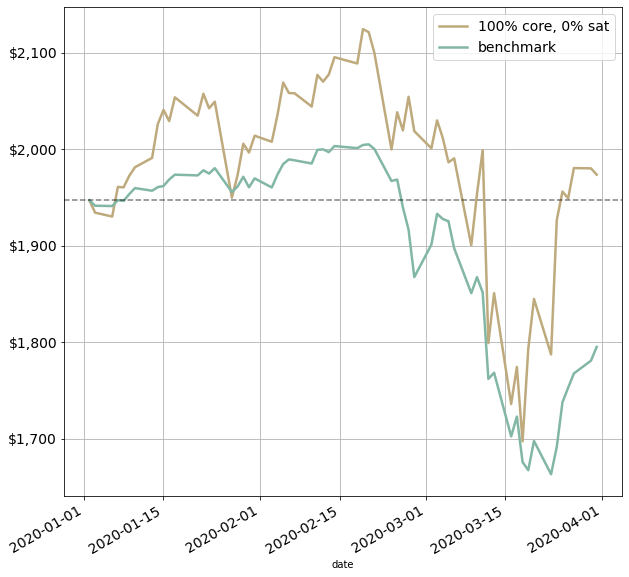

In [9]:
bnh.plot_results()

*Not bad* compared to a standard benchmark portfolio of 60% total market stocks and 40% total market bonds. As you can see, your portfolio was quicker to recover from the dip caused by COVID.

We can also **plot individual asset results** -- was it a good move to trade Chevron for Teladoc?

CVX ending value: $1,175.38
TDOC ending value: $3,624.69


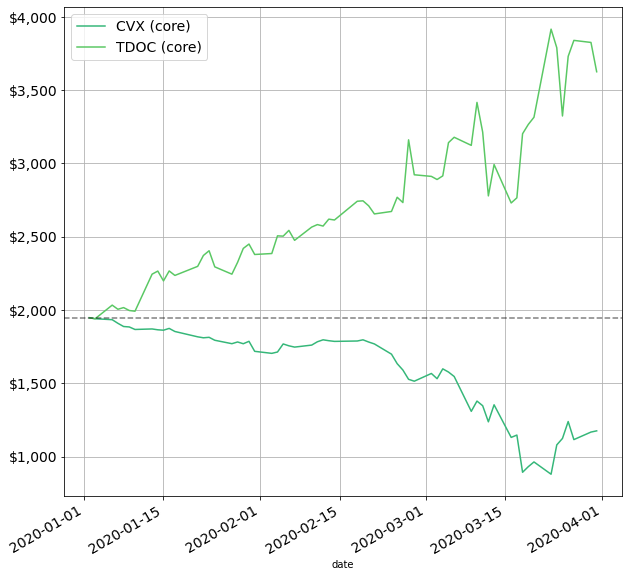

In [10]:
bnh.plot_assets('CVX', 'TDOC')

## Executing a real-life rebalance on April 1. 💧

With a little help, **you can also use a `Strategy` to tell you which rebalance day transactions to make**. To demonstrate, **we'll pretend it's now April 1**, our simulation's next rebalance date (as the zeroth market day of the month following March).

`backstroke`'s data source, Tiingo, only updates its database after closing time on market days, so to get same-day advice, **we have to find and append current prices for all portfolio assets (including benchmarks)**.

_Note that we're now working with `bnh_og`, the pre-sim copy of our original `BuyAndHoldStrategy` instance._

In [11]:
apr1_prices =  {'DIS': 93.5, 'RACE': 151.53, 'EL': 153.03,
                'CVX': 68.55, 'TDOC': 153.5,
                'SPY': 246.89, 'AGG': 114.52}

bnh_og.append_date(pd.Timestamp(2020, 4, 1), apr1_prices)

Once the `Strategy`'s price info is up to date, we can **run `begin_time_loop()` with the 'verbose' argument set to `True`** and **look for the output from the April 1 rebalance** in the resulting printout.

In [12]:
bnh_og.begin_time_loop(verbose=True)

**** on 2020-01-02
total rb; sat_only is False; $1000.00 in account
deltas: [ 2.  1.  1. -4.  5.]
sold 4 shares of CVX @$117.77 | $1471.08 in account
bought 2 shares of DIS @$145.29 | $1180.50 in account
bought 1 shares of RACE @$165.75 | $1014.74 in account
bought 1 shares of EL @$206.00 | $808.75 in account
bought 5 shares of TDOC @$84.00 | $388.75 in account
**** on 2020-02-03
total rb; sat_only is False; $388.75 in account
deltas: [ 0.  0.  0.  0. -1.]
sold 1 shares of TDOC @$102.69 | $491.44 in account
**** on 2020-02-27
received a $0.48 dividend from EL @$185.08 | 0.0047 new shares in account
**** on 2020-03-02
total rb; sat_only is False; $491.44 in account
deltas: [ 1.  1.  0.  0. -1.]
sold 1 shares of TDOC @$126.94 | $618.38 in account
bought 1 shares of DIS @$119.13 | $499.25 in account
bought 1 shares of RACE @$155.15 | $344.10 in account
**** on 2020-04-01
total rb; sat_only is False; $344.10 in account
deltas: [1. 0. 1. 0. 0.]
bought 1 shares of DIS @$93.50 | $250.60 in ac

The printout for April 1 recommends that you **buy one share each of DIS and EL** to rebalance your portfolio. If you trust your `Strategy`, you would then **sign in to your brokerage account and make the corresponding transactions**.

___
## What next?

That should get you started on creating simple portfolios with `backstroke`. To learn about some of the package's more complex Strategies and features, read the [`walkthrough.ipynb`](walkthrough.ipynb) **PROPER LINK** notebook.